In [3]:
import pandas as pd
import torch
from torch import nn
from torchvision.models import resnet18

from memory import log_mem, log_mem_cp
from plot import plot_mem, pp


/home/aiteam/miniconda3/envs/loader/lib/python3.9/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
/home/aiteam/miniconda3/envs/loader/lib/python3.9/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


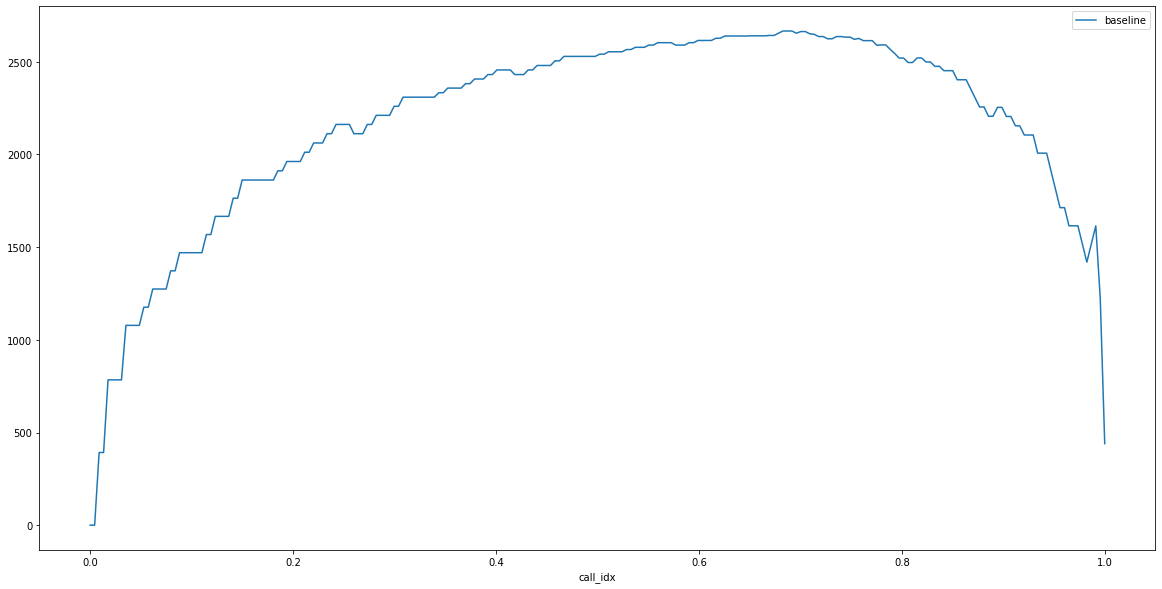

In [5]:
base_dir = '.'
# %% Analysis baseline

model = resnet18().cuda()
bs = 128
input = torch.rand(bs, 3, 224, 224).cuda()

mem_log = []

try:
    mem_log.extend(log_mem(model, input, exp='baseline'))
except Exception as e:
    print(f'log_mem failed because of {e}')

df = pd.DataFrame(mem_log)

plot_mem(df, exps=['baseline'], output_file=f'{base_dir}/baseline_memory_plot_{bs}.png')

In [8]:
df

,layer_idx,call_idx,layer_type,exp,hook_type,mem_all,mem_cached
0,0,0,ResNet,baseline,pre,125324288,4951375872
1,1,1,Conv2d,baseline,pre,125324288,4951375872
2,1,2,Conv2d,baseline,fwd,536366080,4951375872
3,2,3,BatchNorm2d,baseline,pre,536366080,4951375872
4,2,4,BatchNorm2d,baseline,fwd,947408896,4951375872
...,...,...,...,...,...,...,...
605,40,186,BatchNorm2d,3_checkpoints,bwd,356523008,1602224128
606,39,187,Conv2d,3_checkpoints,bwd,333188096,1602224128
607,38,188,ReLU,3_checkpoints,bwd,330828800,1602224128
608,37,189,BatchNorm2d,3_checkpoints,bwd,305140736,1602224128


/home/aiteam/tykim/scratch/profiler/plot.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.call_idx = df_.call_idx / df_.call_idx.max()
/home/aiteam/tykim/scratch/profiler/plot.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.mem_all = df_.mem_all - df_[df_.call_idx == df_.call_idx.min()].mem_all.iloc[0]
/home/aiteam/tykim/scratch/profiler/plot.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

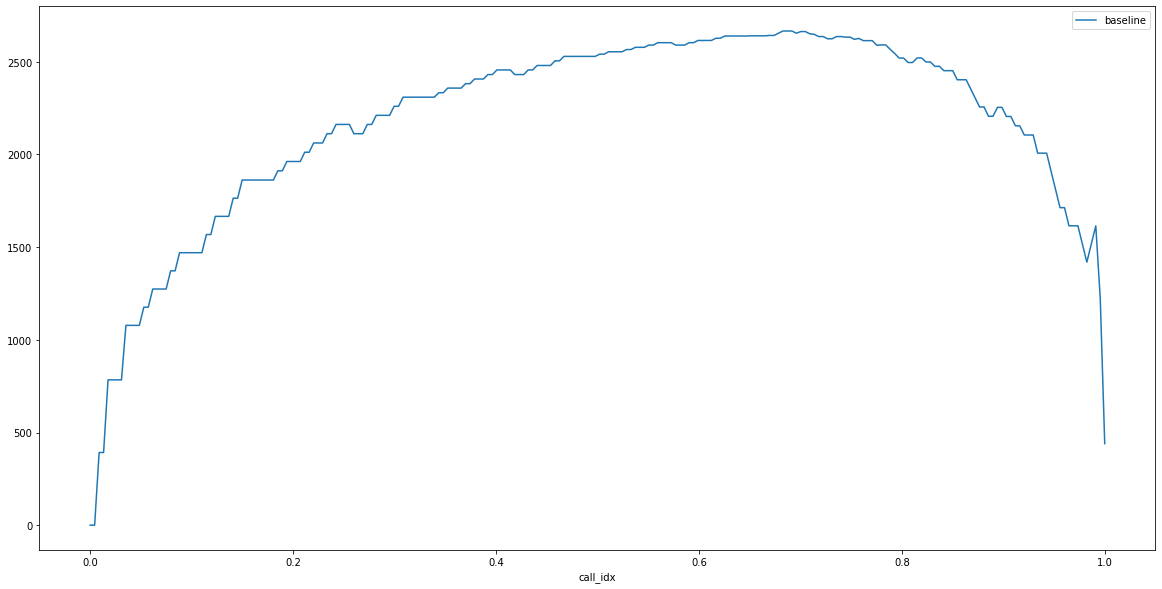

In [7]:
# %% Create Sequential version of model
class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)


seq_model = nn.Sequential(
    model.conv1,
    model.bn1,
    model.relu,
    model.maxpool,
    model.layer1,
    model.layer2,
    model.layer3,
    model.layer4,
    model.avgpool,
    Flatten(),
    model.fc,
)

# %% Test models are identical:

with torch.no_grad():
    out = model(input)
    seq_out = seq_model(input)
    max_diff = (out - seq_out).max().abs().item()
    assert max_diff < 10 ** -10

# %%  Log mem optims

try:
    mem_log.extend(log_mem_cp(seq_model, input, cp_chunks=3, exp='3_checkpoints'))
except Exception as e:
    print(f'log_mem_cp failed because of {e}')

torch.cuda.synchronize()
torch.cuda.empty_cache()


df = pd.DataFrame(mem_log)

plot_mem(df, exps=['baseline'], output_file=f'{base_dir}/baseline_memory_plot_{bs}.png')